# Credit Card Fraud Detection using Anomaly Detection | Part 2 (Tuning)

**Problem**: Predict whether a credit card transaction is fraudulent or not based on its details. Extract the patterns that hint towards fraud by modeling the past transactions such that all frauds are detected and false positives are minimised.

**Solution Framework**: Using "novelty detection" models in a semi-supervised setting which are used to:
- learn what could be the underlying "normal" distribution, by training models on a set of available labeled "normal" data points
- then use those models to validate on "perceived novel" (both normal and anomolous) data points to check what and how much gets predicted as normal or anomalous. 
- Recall, PR-ROC, Precision @t will be used for fine-tuning and evaluation using available labels

**Existing intuitions on algorithms (based on performance on 2D datasets)** -
Source (https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py):
- IF and LOF are good when we have multimodal data. LOF is better when modes have different desities (local aspect of LOF)
- OCSVM is sensitive to outliers and doesn't generally perform well for OD (but good for ND when training data is uncontaminated), but depending on values of hyperparamters it could still give useful results
- EllipticEnvelope assumes Gaussian distribution and thus learns ellipse. Not good for multimodal data but robust to outliers

**Useful material and references**
- https://escholarship.org/uc/item/1f03f6hb#main
- https://www.hindawi.com/journals/complexity/2019/2686378/
- https://imada.sdu.dk/~zimek/InvitedTalks/TUVienna-2016-05-18-outlier-evaluation.pdf
- https://www.gta.ufrj.br/~alvarenga/files/CPE826/Ahmed2016-Survey.pdf
 

## 1. Importing Libraries

In [7]:
#Importing necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
import pickle

#Importing data processing and prep libraries
from sklearn.preprocessing import StandardScaler, RobustScaler   #RobustScaler robust to outliers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold  #for hyperparameter tuning

#Importing machine learning algo libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

#Importing evaluation focussed libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import f1_score, recall_score, average_precision_score

#Other useful libraries
#!pip install missingno   
import missingno as missviz   #Custom library for missing value inspections
from sklearn.manifold import TSNE   #For visualising high dimensional data

## 2. Getting Data
Note: We had saved data as **ADS.pkl** in our working directory from part 1

In [2]:
#Loading the required ADS arrays and their column names
with open("ADS_a.pkl", "rb") as f:
    X_train, y_train, X_test, y_test, X_cols, y_cols = pickle.load(f)

## 3. Hyperparameter Tuning and Model Selection


In [8]:
#Sampling the data first to expedite model training (we'll use "small" data for now, and full data later based on understanding developed from the results on sample)
seed=123
small_frac=0.05
X_train_big, X_train_small, y_train_big, y_train_small = train_test_split(X_train, y_train, test_size=small_frac, random_state=seed)
X_test_big, X_test_small, y_test_big, y_test_small = train_test_split(X_test, y_test, test_size=small_frac, stratify=y_test, random_state=seed)

#Separting "perceived novel" test data into validation (for hyperparameter tuning) and test_ (for performance evaluation)
X_valid_small_, X_test_small_, y_valid_small_, y_test_small_ = train_test_split(X_test_small, y_test_small, test_size=0.2, stratify=y_test_small, random_state=seed)

In [10]:
#Creating a list of models or anomaly detectors
modelname_small=["IF", "LOF", "OCSVM"]

#Creating a dictionary of classifiers and their corresponding hyperparameters grid
hyperparams_small={
    "IF": {"contamination": [0.001, 0.01, 0.025, 0.05, 0.1], "max_samples": list(range(10,300,60)),"n_estimators": [10, 50, 100, 200, 500]},
    "LOF": {"contamination": [0.001, 0.01, 0.025, 0.05, 0.1],"n_neighbors": [5, 10, 20, 50, 100]},
    "OCSVM": {"nu": [0.001, 0.01, 0.025, 0.05, 0.1], "kernel": ['poly', 'rbf', 'linear'], "gamma": np.power(10.0, np.arange(-3,2))}
}

------Passsing training fold # 1 which has 9098 obs------


------Passsing validation fold # 1 which has 16 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 2 which has 17 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 3 which has 19 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 4 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 5 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating 

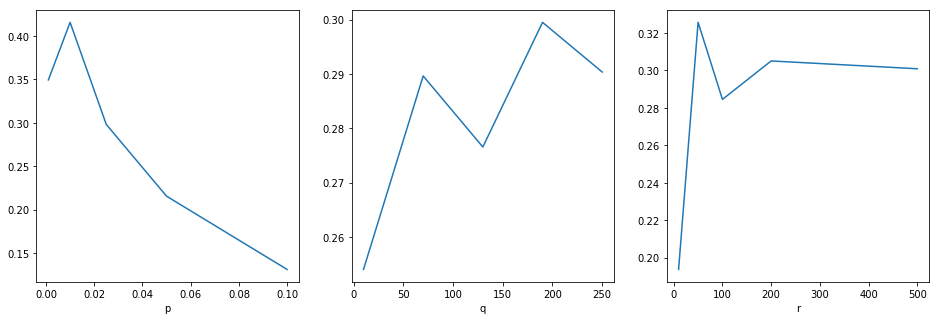

------Plotting valid results for training fold #3 of LOF --------



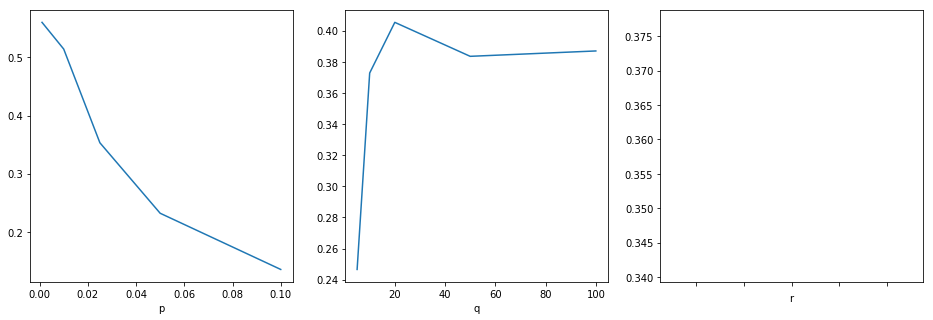

------Plotting valid results for training fold #3 of OCSVM --------

Error occurred
Error occurred
Error occurred


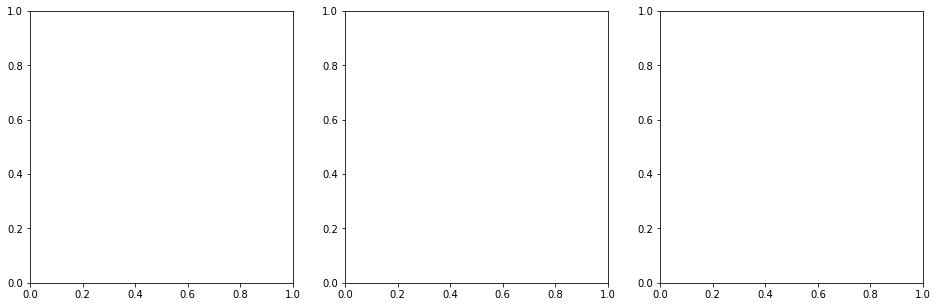

------Passsing training fold # 2 which has 9098 obs------


------Passsing validation fold # 1 which has 16 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 2 which has 17 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 3 which has 19 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 4 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 5 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating 

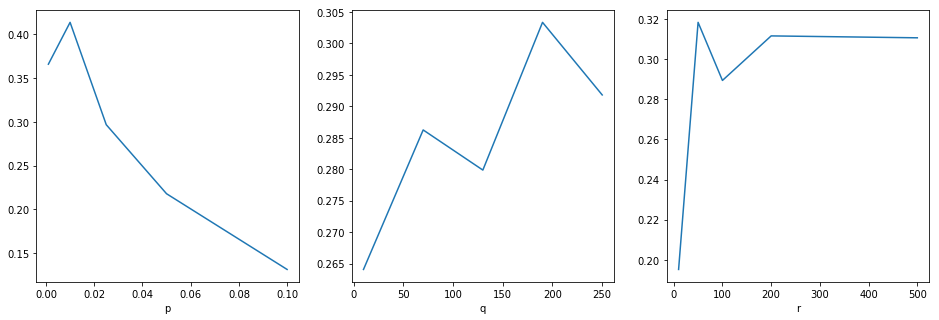

------Plotting valid results for training fold #3 of LOF --------



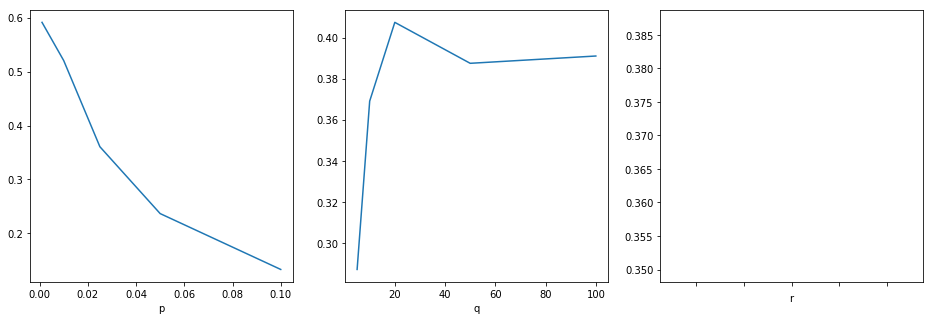

------Plotting valid results for training fold #3 of OCSVM --------

Error occurred
Error occurred
Error occurred


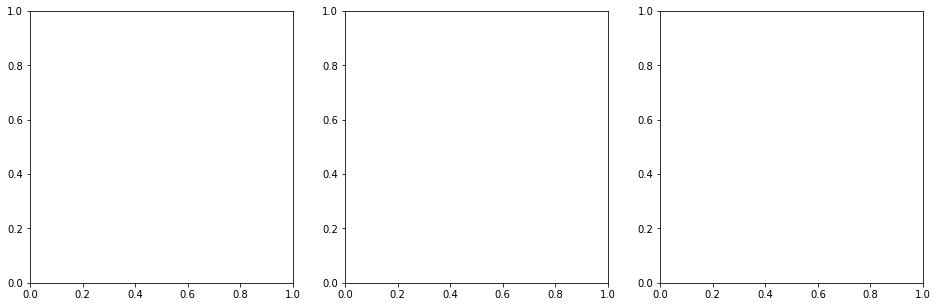

------Passsing training fold # 3 which has 9098 obs------


------Passsing validation fold # 1 which has 16 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 2 which has 17 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 3 which has 19 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 4 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 5 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating 

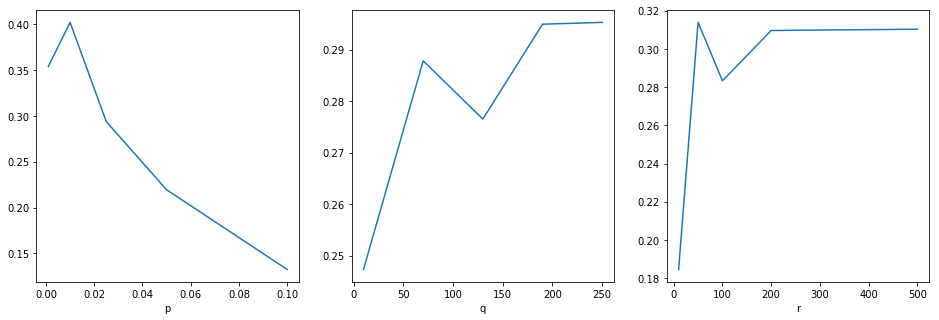

------Plotting valid results for training fold #3 of LOF --------



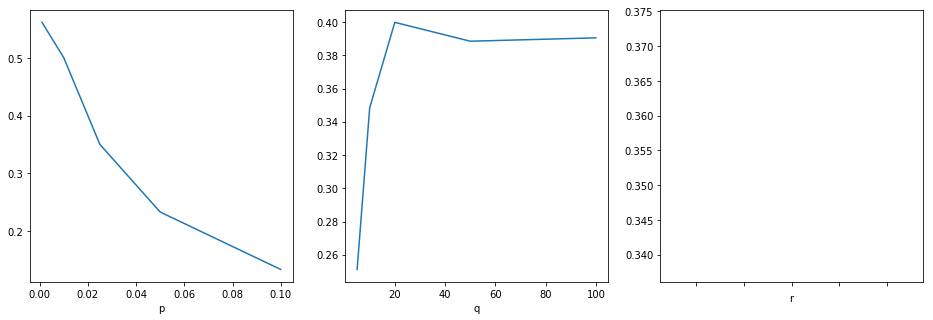

------Plotting valid results for training fold #3 of OCSVM --------

Error occurred
Error occurred
Error occurred


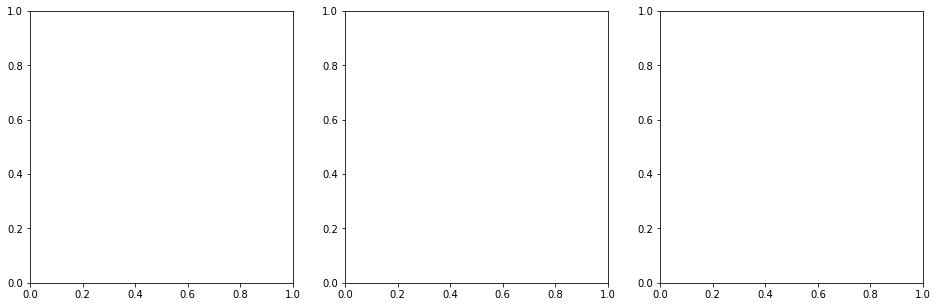

------Passsing training fold # 4 which has 9099 obs------


------Passsing validation fold # 1 which has 16 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 2 which has 17 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 3 which has 19 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 4 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 5 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating 

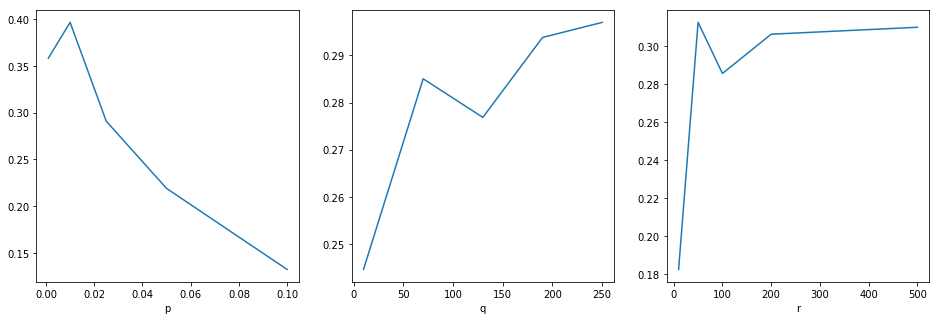

------Plotting valid results for training fold #3 of LOF --------



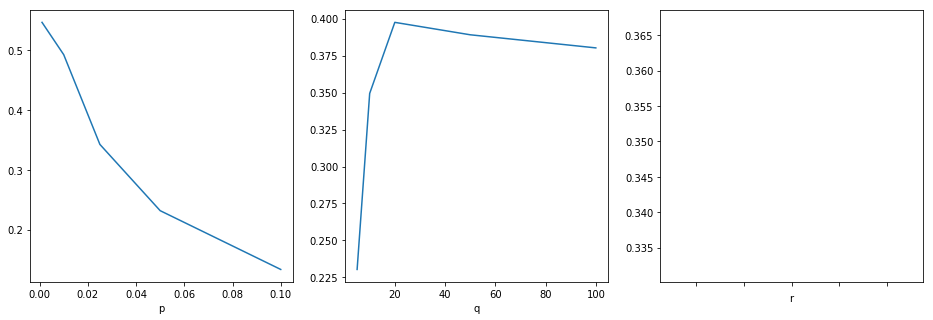

------Plotting valid results for training fold #3 of OCSVM --------

Error occurred
Error occurred
Error occurred


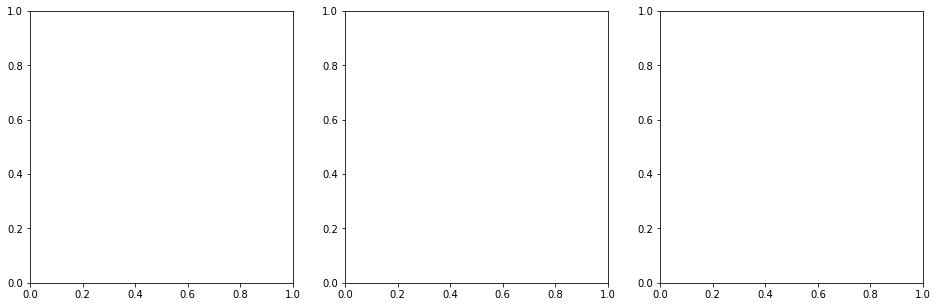

------Passsing training fold # 5 which has 9099 obs------


------Passsing validation fold # 1 which has 16 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 2 which has 17 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 3 which has 19 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 4 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating OCSVM--------

------Passsing validation fold # 5 which has 14 outliers------
------Training and validating IF--------
------Training and validating LOF--------
------Training and validating 

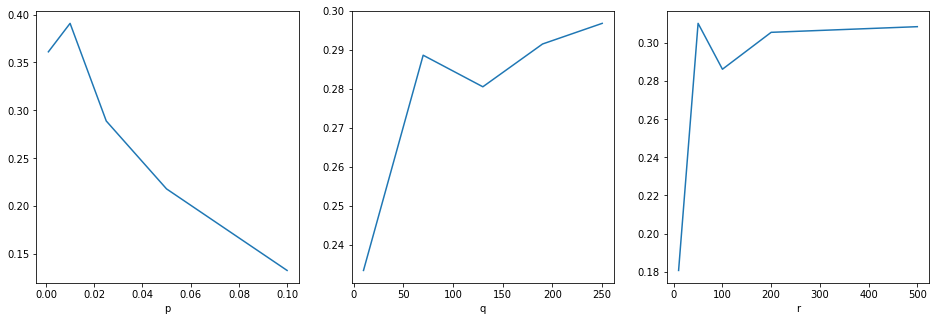

------Plotting valid results for training fold #3 of LOF --------



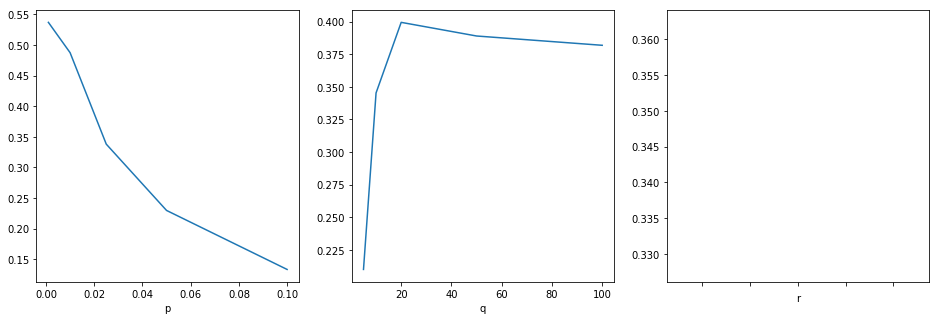

------Plotting valid results for training fold #3 of OCSVM --------

Error occurred
Error occurred
Error occurred


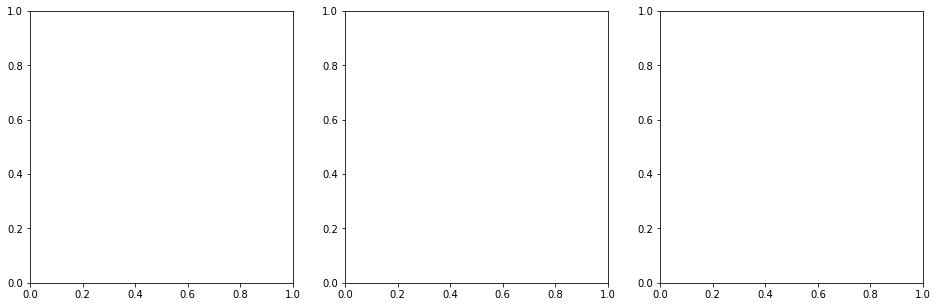

In [124]:
#Training models
results=[]

"""Hyperparameter tuning using K-fold crossvalidation:
    1. K-Split inliers data into train-1 and valid-1 
    2. K-Split inlier + outlier data ("new") into train-2 and valid-2
    3. Training on each train-1, and validating with each train-2 (K*K outputs)

   Note: This was we will:
    1. train model on multiple and varying sets of inliers 
    2. validate on multiple and varying sets of inliers and outliers
        
"""

#Splitting training (inliers) data into train-1 and valid-1
kf_in=KFold(n_splits=5, random_state=seed)
kf_in_out=KFold(n_splits=5, random_state=seed)
for i, (train_small_index, valid_small_index) in enumerate(kf_in.split(X_train_small)):
    X_train_small_1, X_valid_small_1 = X_train_small[train_small_index], X_train_small[valid_small_index]
    y_train_small_1, y_valid_small_1 = y_train_small[train_small_index], y_train_small[valid_small_index]
    print("------Passsing training fold # {I} which has {L} obs------\n".format(I=i+1, L=len(X_train_small_1)))

    #Splitting validation (perceivd novel) data into train-2 and valid-2
    for j, (train_small_index_, valid_small_index_) in enumerate(kf_in_out.split(X_valid_small_)):
        X_train_small_2, X_valid_small_2 = X_valid_small_[train_small_index_], X_valid_small_[valid_small_index_]
        y_train_small_2, y_valid_small_2 = y_valid_small_[train_small_index_], y_valid_small_[valid_small_index_]
        print("\n------Passsing validation fold # {J} which has {M} outliers------".format(J=j+1, M=sum(y_train_small_2)))
        
        #Iterating through mutiple models and their hyperparameters
        for modelname in modelname_small:
            print("------Training and validating {}--------".format(modelname))

            if modelname=="IF":
                for p in hyperparams_small[modelname]["contamination"]:
                    for q in hyperparams_small[modelname]["max_samples"]:
                        for r in hyperparams_small[modelname]["n_estimators"]:

                            #Instantiating model
                            model=IsolationForest(contamination=p, max_samples= q, n_estimators=r, random_state=seed)
                            model.fit(X_train_small_1)
                            y_scores=model.decision_function(X_train_small_2)
                            y_pred=model.predict(X_train_small_2)

                            #The algos predicts {1,-1} for {normal, anomalous} case, whereas original y has {0,1}
                            y_pred=list(map(lambda x: 1 if(x==-1) else 0, y_pred))

                            #Collating results
                            results.append([i+1, j+1, modelname, p, q, r, recall_score(y_train_small_2,y_pred), f1_score(y_train_small_2,y_pred), average_precision_score(y_train_small_2,y_scores)])

            '''
            #Taking a lot of time - We'll test it in google colab
            elif modelname=="OCSVM":
                for p in hyperparams_small[modelname]["nu"]:
                    for q in hyperparams_small[modelname]["kernel"]:
                        for r in hyperparams_small[modelname]["gamma"]:

                            #Instantiating model
                            model=OneClassSVM(nu=p, kernel=q, gamma=r, random_state=seed)
                            model.fit(X_train_small_1)
                            y_scores=model.decision_function(X_train_small_2)
                            y_pred=model.predict(X_train_small_2)

                            #The algos predicts {1,-1} for {normal, anomalous} case, whereas original y has {0,1}
                            y_pred=list(map(lambda x: 1 if(x==-1) else 0, y_pred))

                            #Collating results
                            results.append([i+1, j+1, modelname, p, q, r, recall_score(y_train_small_2,y_pred), f1_score(y_train_small_2,y_pred), average_precision_score(y_train_small_2,y_scores)])

                #Dumping results into a df for pandas manipulation
                results_df=pd.DataFrame(results, columns=["Train", "Valid", "model", "p", "q", "r", "recall", "f1", "PR-AUC"])

                #Best hyperparam combinations of model for iterating train-valid 
                print(results_df.groupby(["model", "p", "q", "r"])[["f1"]].mean().idxmax())
                
                #Plotting results (hyperparams vs mean f1)
                for i,v in enumerate(["p", "q", "r"]):
                    results_df.groupby([v])["f1"].mean().plot(ax=axs[i])
                plt.show()
            
            '''
            
            elif modelname=="LOF":
                for p in hyperparams_small[modelname]["contamination"]:
                    for q in hyperparams_small[modelname]["n_neighbors"]:        
                        r="N/A" 
                        #Instantiating model
                        model=LocalOutlierFactor(contamination=p, n_neighbors=q, novelty=True)
                        model.fit(X_train_small_1)
                        y_scores=model.decision_function(X_train_small_2)
                        y_pred=model.predict(X_train_small_2)

                        #The algos predicts {1,-1} for {normal, anomalous} case, whereas original y has {0,1}
                        y_pred=list(map(lambda x: 1 if(x==-1) else 0, y_pred))

                        #Collating results
                        results.append([i+1, j+1, modelname, p, q, r, recall_score(y_train_small_2,y_pred), f1_score(y_train_small_2,y_pred), average_precision_score(y_train_small_2,y_scores)])
                
            else:
                pass
        
    #Dumping model results for a training fold (and multiple valid-folds, models, hyperparams) into a df for pandas manipulation
    results_df=pd.DataFrame(results, columns=["Train", "Valid", "model", "p", "q", "r", "recall", "f1", "PR-AUC"])

    #Best hyperparam combinations of model for iterating train-valid 
    print(results_df.groupby(["model", "p", "q", "r"])[["f1"]].mean().idxmax())
    print(results_df.groupby(["model", "p", "q", "r"])[["f1"]].mean().max())

    #Plotting results (hyperparams vs mean f1)
    for model in modelname_small:
        fig, axs = plt.subplots(1,3, figsize=(16,5))
        axs=axs.flatten()
        print("------Plotting valid results for training fold #{I} of {m} --------\n".format(I=i+1,m=model))    
        results_df_model=results_df[results_df["model"]==model]
        for i,v in enumerate(["p", "q", "r"]):
            try: 
                results_df_model.groupby([v])["f1"].mean().plot(ax=axs[i])
            except:
                print("Error occurred")        
        plt.show()
                
#Collating results in a df
results_df_main=pd.DataFrame(results, columns=["Train", "Valid", "model", "p", "q", "r", "recall", "f1", "PR-AUC"])